In [52]:
def is_even(n):
    return n % 2 == 0

In [155]:
import math

class ParallelProblem:
    def __init__(self, processors, to_process, to_merge=0):
        self.p = processors
        self.to_process = to_process
        self.to_merge = to_merge
        
    def n_items(self):
        return self.to_process + self.to_merge
        
    def n_sequential_steps(self):
        return 2 * self.n_items() - 1
    
    def solve(self, debug=False):
        if debug:
            print('solving {}'.format(str(self)))
    
        if self.p == 1:  # 1 PU => consume input + merge results
            return self.n_sequential_steps()
        
        # Strategy: process all, then merge all.
        # All this filling all possible resources
        
        slots_available = self.p  # 1 slot for each PU
        
        # first process, then merge
        if self.to_process > 0:  # there are some inputs to process            
            processing_slots = self.to_process if self.to_process <= slots_available else slots_available
            processed = processing_slots  # processing requires 1 item and 1 slot
            left2process = self.to_process - processed
            
            slots_available = slots_available - processing_slots
            merge_slots = math.floor(self.to_merge / 2)
            merge_slots = merge_slots if merge_slots <= slots_available else slots_available
            merged = 2 * merge_slots  # a merge requires 2 items and1 slot
            left2merge = self.to_merge - merged + merge_slots + processed
            
            new_problem = ParallelProblem(self.p, left2process, left2merge)
            return 1 + new_problem.solve()  # this step + recurse
        
        if self.to_merge <= 1:
            return 0
        
        # processed all inputs: merge everything
        merge_slots = math.floor(self.to_merge / 2)
        merge_slots = merge_slots if merge_slots <= slots_available else slots_available
        merged = 2 * merge_slots  # a merge requires 2 items and 1 slot
        left2merge = self.to_merge - merged + merge_slots
        new_problem = ParallelProblem(self.p, 0, left2merge)
        return 1 + new_problem.solve()  # this step + recurse
    
    def n_parallel_steps(self):
        return self.solve()
    
    def speedup(self):
        return self.n_sequential_steps() / self.n_parallel_steps()
    
    def efficiency(self):
        return self.speedup() / self.p
    
    def cost(self):
        # can be anything .. for now I want to maximize the speedup and the efficiency
        return 1 / self.speedup() * 1 / self.efficiency()
    
    def more_speedup_than(self, other):
        return self.speedup() > other.speedup()
    
    def more_efficient_than(self, other):
        return self.efficiency() > other.efficiency()

    def less_cost_than(self, other):
        return self.cost() < other.cost()
    
    def compare(self, other):
        more_speedup = self.more_speedup_than(other)
        more_efficient = self.more_efficient_than(other)
        less_cost = self.less_cost_than(other)
        
        print('{} VS {}'.format(str(self), str(other)))
        print('more speedup? {}'.format(str(more_speedup)))
        print('more efficient? {}'.format(str(more_efficient)))
        print('less cost? {}'.format(str(less_cost)))
    
    def __str__(self):
        return '({}, {}, {})'.format(self.p, self.to_process, self.to_merge)

In [142]:
# taken from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

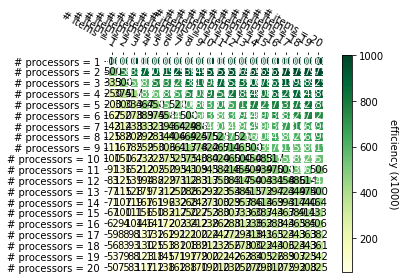

In [160]:
# params
big_p = 20
big_n = 20

# create dataset (matrix)
dataset = np.zeros((big_p, big_n))
for num_p in range(1, big_p + 1):
    for n in range(1, big_n + 1):
        p = ParallelProblem(num_p, n)
        x = 1000 * p.efficiency()
        dataset[num_p - 1, n - 1] = x

# plot as heatmap
labels_p = ['# processors = {}'.format(x) for x in range(1, big_p + 1)]
labels_n = ['# items = {}'.format(x) for x in range(1, big_n + 1)]

fig, ax = plt.subplots()
im, cbar = heatmap(dataset, labels_p, labels_n, ax=ax,
                   cmap="YlGn", cbarlabel="efficiency (x1000)")
texts = annotate_heatmap(im, valfmt="{x:.0f}")
fig.tight_layout()
plt.show()

In [157]:
x = ParallelProblem(20, 400)
print(x.solve())
print(x.speedup(), x.efficiency())

44
18.15909090909091 0.9079545454545455
